In [ ]:
# For Colab
import sys
if 'google.colab' in sys.modules:
    !pip -q install geopandas ortools
    !curl -O https://raw.githubusercontent.com/pjrule/covid-path-planning/master/miller_223.geojson
    !apt -q install imagemagick
else:
    !pip -q install geopandas cvxpy matplotlib scipy ortools

In [1]:
%config InlineBackend.figure_formats = ['svg']
import cvxpy as cp
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from shapely.geometry import box, Point, LineString
from shapely.affinity import scale
from scipy.spatial import distance_matrix
from matplotlib.animation import FuncAnimation
from ortools.constraint_solver import routing_enums_pb2, pywrapcp

In [2]:
class Room:
    """Represents the geometries of a room and its guarded region."""
    def __init__(self, filename, room_res=1000, guard_res=1000, guard_scale=1):
        self.gdf = gpd.read_file(filename)
        self.guard_scale = guard_scale
        self.room = self.gdf[self.gdf['type'] == 'room'].iloc[0].geometry
        self.guard = box(*(scale(self.room, guard_scale, guard_scale).bounds))
        for obs in self.gdf[self.gdf['type'] == 'obstacle'].geometry:
            self.guard = self.guard.difference(obs)
        self.guard = self.guard.intersection(self.room)
        self.room_grid, self.room_cells = self._grid(self.room, room_res)
        self.guard_grid, self.guard_cells = self._grid(self.guard, guard_res)
        
    @property
    def guard_geodesic_center(self):
        """Finds the best guard grid approximation of the room grid's geodesic center."""
        # The geodesic center minimizes the maximum distance to any point.
        dist = distance_matrix(self.guard_grid, self.room_grid)
        return np.argmin(np.max(dist, axis=1))
        
    def _grid(self, geom, res):
        """Returns points within a geometry (gridded over its bounding box).
        
        Points on the grid inside the bounding box but outside the geometry
        are rejected.
        
        :param res: The number of points in the bounding box's grid (approx.)
        """
        minx, miny, maxx, maxy = geom.bounds
        aspect = (maxy - miny) / (maxx - minx)
        n_x_points = int(np.ceil(np.sqrt(res / aspect)))
        n_y_points = int(np.ceil(np.sqrt(res)))
        x_arr, x_epsilon = np.linspace(minx, maxx, n_x_points, retstep = True)
        y_arr, y_epsilon = np.linspace(miny, maxy, n_y_points, retstep = True)
        xx, yy = np.meshgrid(x_arr, y_arr)
        filtered_points = []
        filtered_cells = []
        for x, y in zip(xx.flatten(), yy.flatten()):
            is_in_geom, data = self._get_grid_cell(x, y, x_epsilon, y_epsilon, geom)
            if is_in_geom:
                cell, cell_point = data
                filtered_points.append((cell_point.x, cell_point.y))
                filtered_cells.append(cell)
        return np.array(filtered_points), np.array(filtered_cells)
    
    def _get_grid_cell(self, x, y, x_epsilon, y_epsilon, geom):
        """Computes a grid cell, the intersection of geom and rectangle centered on (x, y)

        Returns a boolean indicating if the grid cell is empty and a data object.
        If the grid cell is not empty, `data` is a tuple of the cell (shapely.Polygon)
        and a point in the cell (shapely.Point)
            
        Throws an error if the grid cell is not a simple polygon.
        """
        minx = x - x_epsilon/2
        maxx = x + x_epsilon/2
        miny = y - y_epsilon/2
        maxy = y + y_epsilon/2
        unfiltered_cell = box(minx = minx, miny = miny, maxx = maxx, maxy = maxy)
        cell = geom.intersection(unfiltered_cell)
        if cell.is_empty:
            is_in_geom = False
            data = None
        else:
            # The cell may consist of two disjoint polygons or may not be simple.
            # This makes checking visibility more difficult and is not currently supported.
            if not cell.geom_type == 'Polygon' or not cell.is_simple:
                raise('Error: A grid cell is not a simple polygon. Increase the grid resolution.')
            is_in_geom = True
            cell_point = cell.representative_point()
            data = (cell, cell_point)
        return is_in_geom, data
        

In [3]:
class Path:
    """A path in a room."""
    def __init__(self, room, robot_height):
        if robot_height <= 0:
            raise PathError('Robot must have a positive height '
                            'to avoid degeneracies.')
        self.room = room
        self.robot_height = robot_height
        self.points = []
        self.room_intensities = None
        self.guard_intensities = None
        
    def __len__(self):
        return len(self.points)
        
    def append(self, index):
        """Adds a point in the guard grid to the path."""
        if index < 0 or index >= self.room.guard_grid.shape[0]:
            raise PathError(f'Point {index} out of bounds!')
        if index in self.points:
            raise PathError(f'Point {index} already in path!')
        self.points.append(index)
        x, y = self.room.guard_grid[index]
        
        room_point_intensities = 1 / ((x - self.room.room_grid[:, 0])**2 + 
                                      (y - self.room.room_grid[:, 1])**2 +
                                      self.robot_height)
        room_point_intensities = room_point_intensities.reshape(1, -1)
        if self.room_intensities is None:
            self.room_intensities = room_point_intensities
        else:
            self.room_intensities = np.append(self.room_intensities,
                                              room_point_intensities,
                                              axis=0)
            
        guard_point_intensities = 1 / ((x - self.room.guard_grid[:, 0])**2 +
                                       (y - self.room.guard_grid[:, 1])**2 +
                                       self.robot_height)
        guard_point_intensities = guard_point_intensities.reshape(1, -1)
        if self.guard_intensities is None:
            self.guard_intensities = guard_point_intensities
        else:
            self.guard_intensities = np.append(self.guard_intensities,
                                               guard_point_intensities,
                                               axis=0)
            
    def filter_path(self, point_indices=None):
        """Returns a `Path` constructed from an iterable of point indices.
        
        For instance, `path.filter_path([0, 1, 2])` constructs a new `Path`
        consisting of the first three points in `path`.
        """
        if point_indices is None:
            point_indices = range(len(self.points))
        filtered_points = []
        for new_idx, old_idx in enumerate(point_indices):
            if old_idx < 0 or old_idx >= self.room.guard_grid.shape[0]:
                raise PathError(f'Point {old_idx} out of bounds!')
            filtered_path.append(self.points[old_idx])
        p = Path(self.room, self.robot_height)
        p.points = filtered_points
        p.room_intensities = self.room_intensities[point_indices]
        p.guard_intensities = self.guard_intensities[point_indices]
        return p
            
    def room_illumination(self):
        """Calculates illumination per unit time on the room grid."""
        if self.room_intensities is None:
            return None
        return self.room_intensities.sum(axis=0)
    
    def guard_illumination(self):
        """Calculates illumination per unit time on the guard grid."""
        if self.guard_intensities is None:
            return None
        return self.guard_intensities.sum(axis=0)
            
    def times(self, min_intensity):
        """Computes minimum time until all points in the room are saturated.
                
        :return: The time spent at each location in the path.
        """
        # Compute times to ensure minimum illumination.
        loc_times = cp.Variable(len(self.points))
        obj = cp.Minimize(cp.sum(loc_times))
        constraints = [
            self.room_intensities.T @ loc_times >= min_intensity,
            loc_times >= 0
        ]
        prob = cp.Problem(obj, constraints=constraints)
        prob.solve()
        assert prob.status == 'optimal'
        return np.array(loc_times.value)    
    
    def route(self, scale_factor=10000):
        """Computes an approximate TSP route for the path.

        Heavily based on examples from:
        https://developers.google.com/optimization/routing/tsp#tsp_py

        :return: A dictionary containing the total length of the path
          and the order of points on the path (represented as path
          indices).
        """
        scaled_locs = np.round(scale_factor *
                               self.room.guard_grid[self.points])
        manager = pywrapcp.RoutingIndexManager(len(self.points), 1, 0)
        routing = pywrapcp.RoutingModel(manager)
        dists = distance_matrix(scaled_locs, scaled_locs)

        def distance_callback(from_index, to_index):
            """Returns the distance between the two nodes."""
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return dists[from_node][to_node]

        callback_index = routing.RegisterTransitCallback(distance_callback)

        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(callback_index)

        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)
        total_distance = 0
        index = routing.Start(0)
        path_indices = []
        while not routing.IsEnd(index):
            path_indices.append(manager.IndexToNode(index))
            prev = index
            index = solution.Value(routing.NextVar(index))
            total_distance += routing.GetArcCostForVehicle(prev, index, 0)
        path_indices.append(manager.IndexToNode(index))

        return {
            'distance': total_distance / scale_factor,
            'path': path_indices
        }
    
    def distance(self):
        """Computes the approximate TSP distance for a path."""
        return self.route()['distance']

class PathError(Exception):
    """Raised for errors in path creation."""

In [4]:
room_file = 'miller_223.geojson'
room_sq_ft = 174
guard_scale = 0.75
robot_height_ft = 4
max_points = 20
min_intensity = 0.1

In [5]:
room = Room(room_file, guard_scale=guard_scale)
room_scale = np.sqrt(room_sq_ft / room.room.area)
robot_height_scaled = robot_height_ft / room_scale

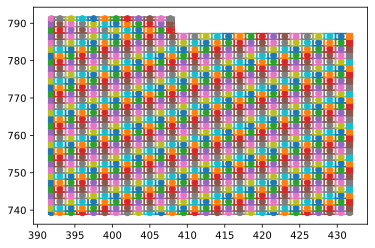

In [6]:
# Visualize the grid cells and the corresponding points
for cell, point in zip(room.room_cells, room.room_grid):
    p = plt.plot(*cell.exterior.xy)
    x, y = point
    plt.plot([x], [y], marker = 'o', color = p[-1].get_color())
plt.show()

## Greedy algorithm
Starting at the geodesic center of the guard region, add the most dimly illuminated point in the guard region until the path has `max_points` points.

In [ ]:
# Starting at the guard geodesic center, greedily add
# the most dimly illuminated room point to the path.
greedy_path = Path(room, robot_height_scaled) 
greedy_path.append(room.guard_geodesic_center)
greedy_tsp_paths = [greedy_path.route(min_intensity)['path']]
greedy_times = [greedy_path.times(min_intensity)]
greedy_t_totals = [greedy_path.times(min_intensity).sum()]
greedy_dist_totals = [greedy_path.distance()]
while len(greedy_path) < max_points:
    for idx in np.argsort(greedy_path.guard_illumination()):
        if idx not in greedy_path.points:
            greedy_path.append(idx)
            break
    times = greedy_path.times(min_intensity)
    greedy_times.append(times)
    greedy_t_totals.append(times.sum())
    route = greedy_path.route()
    greedy_dist_totals.append(route['distance'])
    greedy_tsp_paths.append(route['path'])

In [ ]:
def distance_vs_time(dist_totals, t_totals):
    fig, dist_ax = plt.subplots()
    dist_ax.plot(dist_totals, color='red')
    dist_ax.set_title('Distance and time by path complexity')
    dist_ax.set_xlabel('Number of points in path')
    dist_ax.set_ylabel('Distance', color='red')
    time_ax = dist_ax.twinx()
    time_ax.plot(t_totals, color='blue')
    time_ax.set_ylabel('Time', color='blue')
distance_vs_time(greedy_dist_totals, greedy_t_totals)

## Full LP
Solve for a globally optimal solution (considering all the points in the guard region) and then filter out insignificant points.

In [7]:
room_intensities = 1 / ((np.tile(room.guard_grid[:, 0], (room.room_grid.shape[0], 1)).T -
                         np.tile(room.room_grid[:, 0], (room.guard_grid.shape[0], 1)))**2 + 
                        (np.tile(room.guard_grid[:, 1], (room.room_grid.shape[0], 1)).T -
                         np.tile(room.room_grid[:, 1], (room.guard_grid.shape[0], 1)))**2 +
                        robot_height_scaled)

Removed 1934 broken sightlines


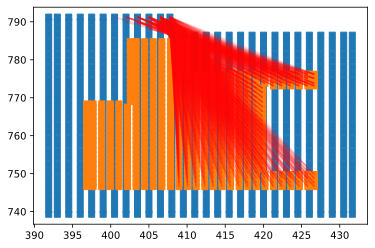

In [8]:
# Patch up visibility. (TODO: make this faster!)
USE_GRID_CELLS = True

ax = plt.axes()
ax.scatter(room.room_grid[:, 0], room.room_grid[:, 1], marker='s')
ax.scatter(room.guard_grid[:, 0], room.guard_grid[:, 1], marker='s')
broken_sightlines_count = 0
broken_sightlines_list = []
for guard_idx, guard_point in enumerate(room.guard_grid):
    for room_idx, room_point in enumerate(room.room_grid):
        if USE_GRID_CELLS:
            # If a point can see all vertices of a simple polygon,
            # then it can see the entire polygon
            room_cell = room.room_cells[room_idx]
            room_cell_points = list(room_cell.exterior.coords)
            sightlines = [LineString([pt, guard_point]) for pt in room_cell_points]
            is_visible = all([room.room.contains(line) for line in sightlines])
        else:
            sight = LineString([guard_point, room_point])
            is_visible = room.room.contains(sight)
        if not is_visible:
            broken_sightlines_list.append((guard_point, room_point))
            broken_sightlines_count += 1
            room_intensities[guard_idx, room_idx] = 0
            
line_collection = LineCollection(broken_sightlines_list, colors = (1,0,0,0.1))
ax.add_collection(line_collection)
print('Removed', broken_sightlines_count, 'broken sightlines')

In [9]:
loc_times = cp.Variable(room.guard_grid.shape[0])
obj = cp.Minimize(cp.sum(loc_times))
constraints = [
    room_intensities.T @ loc_times >= min_intensity,
    loc_times >= 0
]
prob = cp.Problem(obj, constraints=constraints)
prob.solve(solver='ECOS')

44.139786690753915

In [10]:
lp_solution = loc_times.value / loc_times.value.sum()
n_significant_points = lp_solution[lp_solution > 1e-2].size
trimmed_path_indices = np.argsort(lp_solution)[-n_significant_points:]
lp_path = Path(room, robot_height_scaled)
for idx in trimmed_path_indices:
    lp_path.append(idx)

In [11]:
def animate_path(path, filename, height=500, dpi=100, duration=5, fps=10):
    minx, miny, maxx, maxy = room.room.bounds
    aspect_ratio = (maxy - miny) / (maxx - minx)
    width = int(height / aspect_ratio)
    pixels = np.zeros((height, width))
    xx = np.linspace(minx, maxx, width)
    yy = np.linspace(miny, maxy, height)
    X, Y = np.meshgrid(xx, yy)
    coords = np.array([X.flatten(), Y.flatten()])
    pixel_illuminations = np.zeros((len(path), height, width))
    # Display points in TSP order.
    route = [path.points[idx] for idx in path.route()['path'][:-1]]
    tsp_order = [route.index(p) for p in path.points]
    times = np.zeros(len(path))
    for idx, t in enumerate(path.times(1)):
        times[tsp_order[idx]] = t
    times /= times.sum()
    
    # Mask off the room polygon.
    mask = np.zeros(height * width)
    for idx, (x, y) in enumerate(coords.T):
        if room.room.contains(Point(x, y)):
            mask[idx] = 1
    mask = mask.reshape(height, width)
    
    # Calculate illumination per unit time from each path on the point.
    for idx, point in enumerate(route):
        x, y = room.guard_grid[point]
        point_illumination = 1 / ((x - coords[0])**2 +
                                  (y - coords[1])**2 +
                                  path.robot_height)
        pixel_illuminations[idx] = point_illumination.reshape(height,
                                                              width)

    # How much light should be received for each frame?
    n_frames = int(duration * fps) - 1
    weights = np.zeros((n_frames, len(path)))
    cum_times = np.cumsum(times)
    for idx in range(n_frames):
        percent_done = (idx + 1) / n_frames
        for path_idx, t in enumerate(cum_times):
            if t <= percent_done:
                weights[idx, path_idx] = times[path_idx]
            else:
                if path_idx > 0:
                    weights[idx, path_idx] = percent_done - cum_times[path_idx - 1]
                else:
                    weights[idx, path_idx] = percent_done
                break
        
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    ax.axis('off')
    im = ax.imshow(np.zeros((height, width)), cmap='hot', vmin=0, vmax=0.025)
    def im_update(i):
        total_illumination = np.zeros((height, width))
        for w_idx, w in enumerate(weights[i]):
            total_illumination += w * pixel_illuminations[w_idx]
        points_on_path = [route[idx]
                          for idx in np.where(weights[i] > 0)[0]]
        if i == n_frames - 1:
            # Close path.
            points_on_path.append(route[0])
        for l, r in zip(points_on_path[:-1], points_on_path[1:]):
            xl, yl = room.guard_grid[l]
            xr, yr = room.guard_grid[r]
            xl = width * (xl - minx) / (maxx - minx)
            xr = width * (xr - minx) / (maxx - minx)
            yl = height * (yl - miny) / (maxy - miny)
            yr = height * (yr - miny) / (maxy - miny)
            ax.plot([xl, xr], [yl, yr], color='white', linewidth=2, zorder=4)
        
        im.set_data(mask * total_illumination)
    anim = FuncAnimation(fig, im_update,
                         frames=np.arange(n_frames),
                         interval=1000 / fps)
    anim.save(filename, writer='imagemagick', dpi=dpi)

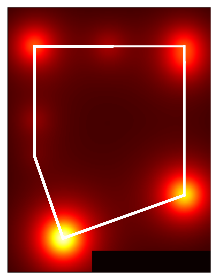

In [12]:
animate_path(lp_path, 'lp.gif', dpi=300)

## Evolutionary algorithm
Generate paths by combination and mutation, starting from an initial population of random paths.

In [ ]:
pop_size = 60
n_keep_elite = 10
n_random = 10
candidate_points = 10
n_generations = 30
alpha = 1
n_parents = 2

In [ ]:
def eval_population(pop):
    """Evaluates a population by time."""
    times = []
    time_sums = []
    for candidate in pop:
        path = Path(room, robot_height_scaled)
        for point in candidate:
            path.append(point)
        t = path.times(min_intensity)
        times.append(t)
        time_sums.append(t.sum())
    return time_sums, times

def next_gen(pop, scores, subscores):
    """Generates a new population."""
    pop = np.array(pop)
    scores = np.array(scores)
    subscores = np.array(subscores)
    elite = np.argsort(scores)[:n_keep_elite]
    new_pop = [pop[idx] for idx in elite]
    normalized_scores = (scores - scores.min()) / (scores.max() - scores.min())
    weights = np.exp(-normalized_scores * alpha)
    weights /= weights.sum()
    for _ in range(pop_size - n_keep_elite - n_random):
        # Use the `candidate_points` most important points.
        parents = np.random.choice(pop_size, n_parents)
        unique_indices = np.unique(pop[parents].flatten(), return_index=True)[1]
        parent_points = pop[parents].flatten()[unique_indices]
        parent_subscores = subscores[parents].flatten()[unique_indices]
        subscore_rank = np.argsort(parent_subscores)
        new_candidate = parent_points[subscore_rank[-candidate_points:]]
        new_pop.append(new_candidate)
    new_pop += [np.random.choice(room.guard_grid.shape[0], candidate_points, replace=False)
                for _ in range(n_random)]
    return new_pop

In [ ]:
population = [np.random.choice(room.guard_grid.shape[0], candidate_points, replace=False)
              for _ in range(pop_size)]

for _ in range(n_generations):
    scores, subscores = eval_population(population)
    print('best:', np.min(scores))
    population = next_gen(population, scores, subscores)

In [ ]:
def time_spent_on_path(room, path, times, scale=200):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    minx, miny, maxx, maxy = room.room.bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    for path_idx, grid_idx in enumerate(greedy_path.points):
        x, y = room.guard_grid[grid_idx]
        ax.scatter([x], [y], color='red', s=[scale * times[path_idx]])
    ax.set_title('Relative time spent on path')
time_spent_on_path(room, greedy_path, greedy_times[-1])
plt.show()